# Introduction

What this notebook is try to accomplish is looking at the credit card records from roughly 285,000 transactions and trying to create a model which will predict if the transaction was fraudulent activity or not. This dataset same from the site kaggle.com. Probably identifying whether a transaction is fraudulent or not is a classifiaction problem and I will be using various tuned model in aiding me in properly labeling these different credit card activity between no fraud and fraud.

# Import Packages

In [1]:
#import packages.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline 
import pandas as pd
import seaborn as sns
import sys
import itertools
import random
#From Scikit Learn
from sklearn import preprocessing
from sklearn.model_selection  import train_test_split, cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from itertools import product
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import operator

# Set Seed

In [2]:
random.seed(0)

# Custom Packages

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.YlOrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
        print()
    else:
        #print('Confusion matrix, without normalization')
        print()

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='label')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        y : array-like, shape = [n_samples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_samples, n_classes]
            Weighted average probability for each class per sample.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

# Import Data

In [5]:
#Reading in Churn dataset
df=pd.read_csv("./creditcard.csv")
#Showing first ten rows
df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


# Set Target Class

In [6]:
#Designate target variable name
targetName = 'Class'
targetSeries = df[targetName]
#Remove target from current location and insert in column 0
del df[targetName]
df.insert(0, targetName, targetSeries)

# Restructure Amount Variable

In [7]:
del df['Time']
#Reprint dataframe and see target is in position 0
df['Amount_Z'] = ((df['Amount']-df['Amount'].mean())/df['Amount'].std())
del df['Amount']

In [24]:
df.head(10)

,Class,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount_Z
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342474
2,0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160684
3,0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534
4,0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403
5,0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,-0.338556
6,0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.219633,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,-0.333278
7,0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,-0.156742,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,-0.190107
8,0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,0.052736,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,0.019392
9,0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,0.203711,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,-0.338516


# Exploratory Data Anaylsis

## Target Class Breakdown

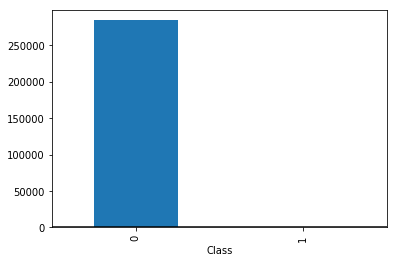

In [9]:
groupby = df.groupby(targetName)
targetEDA=groupby[targetName].aggregate(len)
plt.figure()
targetEDA.plot(kind='bar', grid=False)
plt.axhline(0, color='k')

In [10]:
targetEDA

Class
0    284315
1       492
Name: Class, dtype: int64

In understanding how skewed the data is, I know that I will have to be careful when working on building models to look at measures other than just accuarcy. If we are looking sololy at the overall accuracy then just guessing no fraud on all orders will create an accuracy around 99.9%, but what we are trying to do is to stop fraud, so this is something that I've have to work with to get the results that I need.

## Variable Histograms

In [12]:
cols = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount_Z']

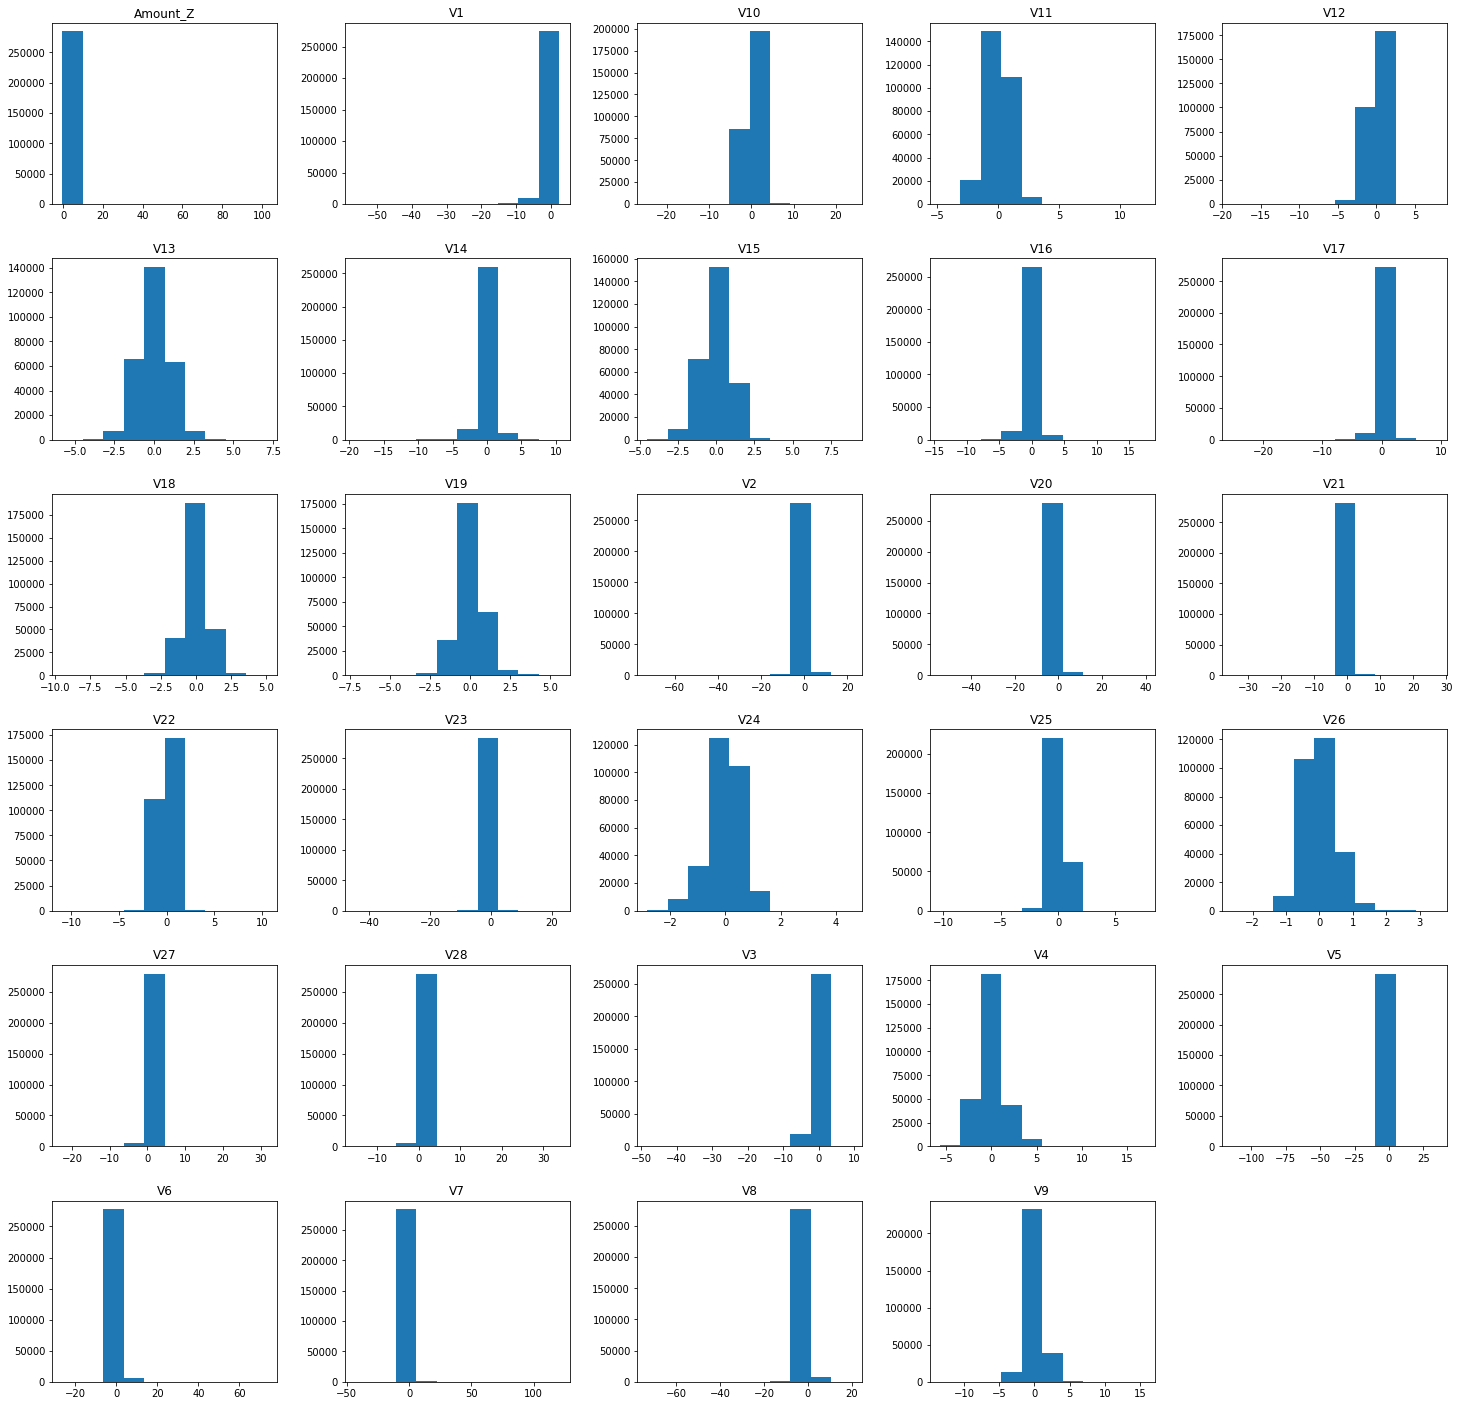

In [13]:
# create a histogram matrix
plt.figure()
df[cols].hist(figsize=(25, 25), grid=False)
plt.show()

The way the data was presented, with it already being normalized except for the amount of the charge there is not a ton that we can learn from understanding that the variables are indeed normalized, but I thought it was still worth checking to make sure that all the variables looked normallized and I wasn't making any decisions off assumptions alone.

## Varaible Description

In [14]:
df.describe()

,Class,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount_Z
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05
mean,0.001727,1.758743e-12,-8.252298e-13,-9.636929e-13,8.316157e-13,1.591952e-13,4.247354e-13,-3.050180e-13,8.693344e-14,-1.179712e-12,...,1.766038e-12,-3.406543e-13,-5.713163e-13,-9.725303e-13,1.464139e-12,-6.989087e-13,-5.615260e-13,3.332112e-12,-3.518886e-12,2.262609e-13
std,0.041527,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,1.000000e+00
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,-3.532288e-01
25%,0.000000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,-3.308395e-01
50%,0.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,-2.652710e-01
75%,0.000000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,-4.471699e-02
max,1.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,1.023621e+02


In looking at the different histograms and the variable descriptions, it helps to understand how wide spread some of the variables actually are separated.

# Training and Testing Split

In [9]:
# split dataset into testing and training
features_train, features_test, target_train, target_test = train_test_split(
    df.iloc[:,1:].values, df.iloc[:,0].values, test_size=0.30, random_state=0)

In [18]:
print(features_test.shape)
print(features_train.shape)
print(target_test.shape)
print(target_train.shape)

(85443, 29)
(199364, 29)
(85443,)
(199364,)


# Building and Testing Models

In looking for models that do the best at predicitng fraudulent credit card activity the measure that I want to focus on is recall. This measures how many of well the model did correctly predicting fraudalent activity viruses the fraudelent activity the model missed. Focusing sololy on recall may lead to an increase of false positive results, but for right now it I think it is more import to stop the actually fraud then wrongly classifying a portion. As a secondary measure I wanted to focus on AUC scores, which measures how often the model correctly labels results that are fraud against those that are not fruad, this will help to determine that there are not too many false positive results that occur.

In building the models I wanted to use cross valiadation for the grid search, but then I just use a single result for the first recall and AUC results, then I was going to us cross valiadation of all the models together to compare all the results together. Also for all the grid searches I am using, I am having the grid search function look for the model with the best recall score opposed to the best accuracy.

## Gaussian Naive Bayes

The first classifier I want to take a look at is just a Gaussian Naive Bayes to get a good baseline with a simple classifier.

In [19]:
#Set clf function
gnb = GaussianNB()
#Fit clf to the training data
gnb =gnb.fit(features_train, target_train)
#Predict clf model again test data
target_predicted_gnb = gnb.predict(features_test)
print("Gaussian Naive Bayes Recall Score", recall_score(target_test, target_predicted_gnb))
print(classification_report(target_test, target_predicted_gnb,target_names=['No Fraud', 'Fraud']))

Gaussian Naive Bayes Recall Score 0.836734693878
             precision    recall  f1-score   support

   No Fraud       1.00      0.98      0.99     85296
      Fraud       0.06      0.84      0.12       147

avg / total       1.00      0.98      0.99     85443



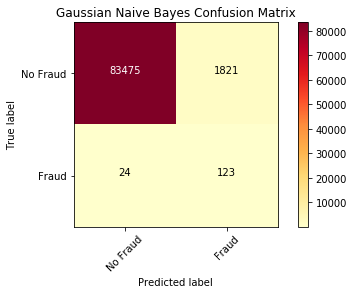

In [20]:
#Create confusion matrix
cnf_matrix = confusion_matrix(target_test, target_predicted_gnb)
#Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Fraud', 'Fraud'],
                      title='Gaussian Naive Bayes Confusion Matrix')

plt.show()

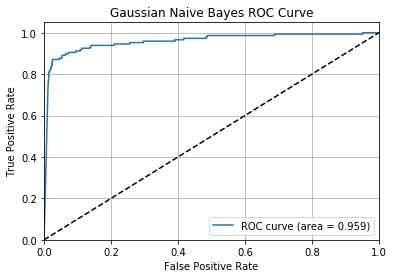

In [21]:
# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(target_test, gnb.predict_proba(features_test)[:,1]) 
    
# Calculate the AUC
roc_auc = auc(fpr, tpr)
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gaussian Naive Bayes ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

This seems like a good place to start with creating models, with a recall rate of .837% and an AUC of .959. It was good simple first model.

## Logistic Regression

The next model I want to look at is a logistic regression classifier. With this model I am going to us grid search to find the best penalty type for the model, whether that is L1 or L2, and the weight of the penalty known as the C variable.

In [22]:
#Set clf function
lr = LogisticRegression(random_state=0,)
#Print clf function
print(lr)
#Set parameters
parameters = {'penalty':['l2','l1'],'C': [.001,.01,.1,1,10]}
#Set grid search function
grid_search = GridSearchCV(lr,parameters,cv=5,scoring='recall')
#Run grid search
grid_search.fit(features_train, target_train)
print("Best:", grid_search.best_params_)  

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Best: {'C': 10, 'penalty': 'l2'}


In [90]:
lr = LogisticRegression(penalty='l2', C=10, random_state=0)
#Fit clf to the training data
lr = lr.fit(features_train, target_train)
#Predict clf model again test data
target_predicted_lr = lr.predict(features_test)
print("Logistic Regression Recall Score", recall_score(target_test, target_predicted_lr))
print(classification_report(target_test, target_predicted_lr,target_names=['No Fraud', 'Fraud']))

Logistic Regression Recall Score 0.619047619048
             precision    recall  f1-score   support

   No Fraud       1.00      1.00      1.00     85296
      Fraud       0.88      0.62      0.73       147

avg / total       1.00      1.00      1.00     85443



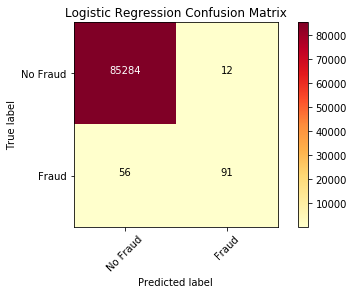

In [91]:
#Create confusion matrix
cnf_matrix = confusion_matrix(target_test, target_predicted_lr)
#Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Fraud', 'Fraud'],
                      title='Logistic Regression Confusion Matrix')

plt.show()

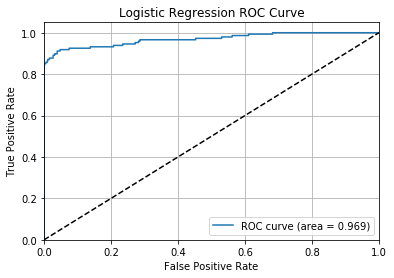

In [92]:
# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(target_test, lr.predict_proba(features_test)[:,1]) 
    
# Calculate the AUC
roc_auc = auc(fpr, tpr)
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

The linear regression model that was found to be the best by grid search has a L2 penalty with a C value of 1.0. This model only has a recall of .612 which is worst than the first model but it has a AUC of .969 which seems to be better.

## Knn

For the K-nearest neighbor model I wanted to compare which weighting system yeilded the best results along with the number of neighbors the model should have.

In [26]:
#Set clf function
knn = KNeighborsClassifier(n_jobs=-1)
#Print clf function
print(knn)
#Set parameters
parameters = {'weights':['uniform','distance'],'n_neighbors': [1,2,3,4,5]}
#Set grid search function
grid_search = GridSearchCV(knn,parameters,cv=5, scoring='recall')
#Run grid search
grid_search.fit(features_train, target_train)
print("Best:", grid_search.best_params_)  

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')
Best: {'n_neighbors': 1, 'weights': 'uniform'}


In [27]:
#Set clf function
knn = KNeighborsClassifier(n_neighbors=1,weights='uniform',n_jobs=-1)
#Fit clf to the training data
knn = knn.fit(features_train, target_train)
#Predict clf DT model again test data
target_predicted_knn = knn.predict(features_test)
print("KNN Recall Score", recall_score(target_test, target_predicted_knn))
print(classification_report(target_test, target_predicted_knn,target_names=['No Fraud', 'Fraud']))

KNN Recall Score 0.789115646259
             precision    recall  f1-score   support

   No Fraud       1.00      1.00      1.00     85296
      Fraud       0.89      0.79      0.83       147

avg / total       1.00      1.00      1.00     85443



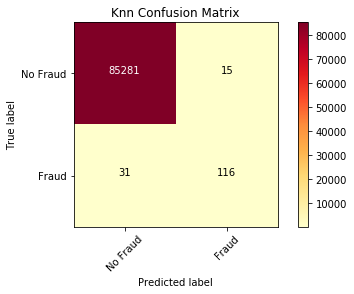

In [28]:
#Create confusion matrix
cnf_matrix = confusion_matrix(target_test, target_predicted_knn)
#Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Fraud', 'Fraud'],
                      title='Knn Confusion Matrix')

plt.show()

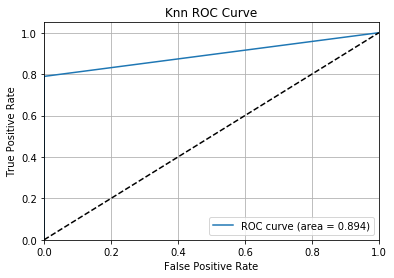

In [29]:
# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(target_test, knn.predict_proba(features_test)[:,1]) 
    
# Calculate the AUC
roc_auc = auc(fpr, tpr)
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Knn ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

For the Knn the best recall results was found to be with a uniform weight and only using 1 nearest neighbor. The recall score performed fairly well .789 but this model gave us our lowest AUC score yet with .894.

## Decision Tree

The next classifier model I wanted to try was a decision tree. I used the grid search to find the best splitting criterion between Gini and Enthropy, the best way to split wether using the best split or a random split, the whether max features should be determined by square root or the log 2 of the number of features or if this should not be used at all, and whether there should be a balanced class weight or not.

In [30]:
#Set clf function
dt = DecisionTreeClassifier(random_state=0)
#Print clf function
print(dt)
#Set parameters
parameters = {'criterion': ('gini','entropy'), 'splitter':['best','random'],'max_features': [None, 'sqrt', 'log2'],'class_weight':[None,'balanced']}
#Set grid search function
grid_search = GridSearchCV(dt,parameters,cv=5, scoring='recall')
#Run grid search
grid_search.fit(features_train, target_train)
print("Best:", grid_search.best_params_)  

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')
Best: {'class_weight': None, 'criterion': 'entropy', 'max_features': None, 'splitter': 'best'}


In [93]:
#Set clf function
dt = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_features=None, splitter='best',random_state=0)
#Fit clf to the training data
dt = dt.fit(features_train, target_train)
#Predict clf DT model again test data
target_predicted_dt = dt.predict(features_test)
print("Desicion Tree Recall Score", recall_score(target_test, target_predicted_dt))
print(classification_report(target_test, target_predicted_dt,target_names=['No Fraud', 'Fraud']))

Desicion Tree Recall Score 0.734693877551
             precision    recall  f1-score   support

   No Fraud       1.00      1.00      1.00     85296
      Fraud       0.79      0.73      0.76       147

avg / total       1.00      1.00      1.00     85443



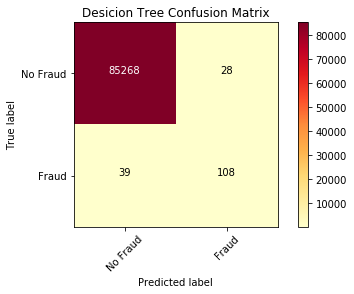

In [94]:
#Create confusion matrix
cnf_matrix = confusion_matrix(target_test, target_predicted_dt)
#Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Fraud', 'Fraud'],
                      title='Desicion Tree Confusion Matrix')

plt.show()

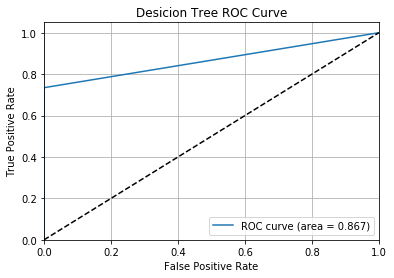

In [95]:
# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(target_test, dt.predict_proba(features_test)[:,1]) 
    
# Calculate the AUC
roc_auc = auc(fpr, tpr)
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Desicion Tree ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

From the grid search the best model uses the splitting criterion of Enthropy, using the best splitter to split branches of the decision tree, with no max feature constrants and without a balanced class weight. The results from decision tree model was a recall of .735 and AUC of .867, which is the one of the lowest recall scores so far and the lowest AUC thus far.

## Random Forest

For the random forest modeling, grid search will be used to find the best number of estimators between 10, 20, 50 and 100, the best splitting criterion between Gini and Enthropy, the whether max features should be determined by square root or the log 2 of the number of features or if this should not be used at all, and whether there should be a balanced class weight or not. Since random forest is a combination of decision tree at the very least this model should definitely preform better than our decision tree model.

In [34]:
#Set clf function
rf = RandomForestClassifier(random_state=0,n_jobs=-1)
#Print clf function
print(rf)
#Set parameters
parameters = {'n_estimators':[10,20,50,100],'criterion': ('gini','entropy'),'max_features': [None, 'sqrt', 'log2'],'class_weight':[None,'balanced']}
#Set grid search function
grid_search = GridSearchCV(rf,parameters,cv=5, scoring='recall')
#Run grid search
grid_search.fit(features_train, target_train)
print("Best:", grid_search.best_params_)  

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)
Best: {'class_weight': None, 'criterion': 'gini', 'max_features': None, 'n_estimators': 100}


In [96]:
#Set clf function
rf = RandomForestClassifier(class_weight=None, criterion='gini', max_features=None, n_estimators=100, random_state=0)
#Fit clf to the training data
rf = rf.fit(features_train, target_train)
#Predict clf DT model again test data
target_predicted_rf = rf.predict(features_test)
print("Random Forest Recall Score", recall_score(target_test, target_predicted_rf))
print(classification_report(target_test, target_predicted_rf,target_names=['No Fraud', 'Fraud']))

Random Forest Recall Score 0.775510204082
             precision    recall  f1-score   support

   No Fraud       1.00      1.00      1.00     85296
      Fraud       0.94      0.78      0.85       147

avg / total       1.00      1.00      1.00     85443



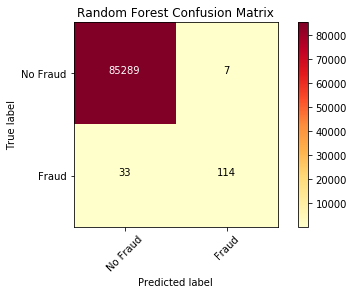

In [97]:
#Create confusion matrix
cnf_matrix = confusion_matrix(target_test, target_predicted_rf)
#Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Fraud', 'Fraud'],
                      title='Random Forest Confusion Matrix')

plt.show()

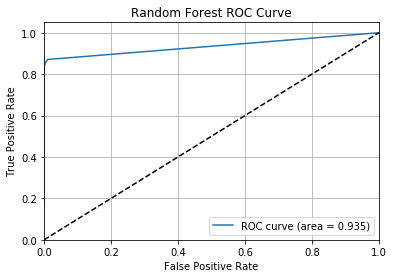

In [98]:
# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(target_test, rf.predict_proba(features_test)[:,1]) 
    
# Calculate the AUC
roc_auc = auc(fpr, tpr)
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

It was found the random forest with the best results had 100 estimators, using the Gini splitting criterion, with no max feature constrants and without a balanced class weight. As excepted the results from the random forest model is better than the single decision tree model, with a recall score of .776 and an AUC score of .935.

## SVM Linear

The next model to be examined is a Support Vector Machine model using a linear kernel. With this model I will be using the grid search function to find the best penalty parameter, known as C, from .001, .01, .1, 1, and 10. 

In [38]:
#Set clf function
svm_l = SVC(kernel='linear',random_state=0,probability=True)
#Print clf function
print(svm_l)
#Set parameters
parameters = { 'C':[.001,.01,.1,1,10]}
#Set grid search function
grid_search = GridSearchCV(svm_l, parameters, cv=5, scoring='recall')
#Run grid search
grid_search.fit(features_train, target_train)
print("Best:", grid_search.best_params_)  

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
  verbose=False)
Best: {'C': 0.1}


In [99]:
#Set clf function
svm_l = SVC(C=0.01,kernel='linear',random_state=0,probability=True)
#Fit clf to the training data
svm_l = svm_l.fit(features_train, target_train)
#Predict clf DT model again test data
target_predicted_svm_l = svm_l.predict(features_test)
print("SVM Linear Recall Score", recall_score(target_test, target_predicted_svm_l))
print(classification_report(target_test, target_predicted_svm_l,target_names=['No Fraud', 'Fraud']))

SVM Linear Recall Score 0.768707482993
             precision    recall  f1-score   support

   No Fraud       1.00      1.00      1.00     85296
      Fraud       0.83      0.77      0.80       147

avg / total       1.00      1.00      1.00     85443



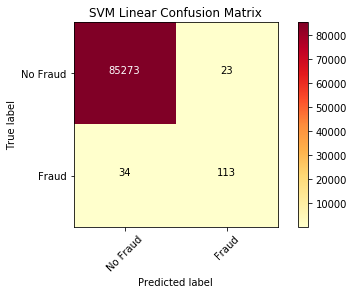

In [100]:
#Create confusion matrix
cnf_matrix = confusion_matrix(target_test, target_predicted_svm_l)
#Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Fraud', 'Fraud'],
                      title='SVM Linear Confusion Matrix')

plt.show()

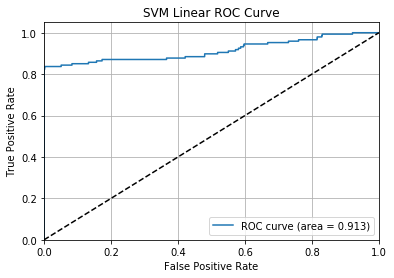

In [101]:
# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(target_test, svm_l.predict_proba(features_test)[:,1]) 
    
# Calculate the AUC
roc_auc = auc(fpr, tpr)
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM Linear ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

The grid search function found that the best penalty parameter to use the SVM with a linear kernel was .01, giving the model a recall score of .769 and an AUC score of .913.

## SVM RBF

Now that the linear kernel with the Support Vector Machine has been examined, we will try the using an RBF kernel instead, still using the grid serach function to find the best penalty parameter, known as C, from .001, .01, .1, 1, and 10 for the model. 

In [42]:
#Set clf function
svm_rbf = SVC(kernel='rbf',random_state=0,probability=True)
#Print clf function
print(svm_rbf)
#Set parameters
parameters = { 'C':[.001,.01,.1,1,10]}
#Set grid search function
grid_search = GridSearchCV(svm_rbf, parameters, cv=5, scoring='recall')
#Run grid search
grid_search.fit(features_train, target_train)
print("Best:", grid_search.best_params_)  

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
  verbose=False)
Best: {'C': 10}


In [43]:
#Set clf function
svm_rbf = SVC(C=10,kernel='rbf',random_state=0,probability=True)
#Fit clf to the training data
svm_rbf = svm_rbf.fit(features_train, target_train)
#Predict clf DT model again test data
target_predicted_svm_rbf = svm_rbf.predict(features_test)
print("SVM RBF Recall Score", recall_score(target_test, target_predicted_svm_rbf))
print(classification_report(target_test, target_predicted_svm_rbf,target_names=['No Fraud', 'Fraud']))

SVM RBF Recall Score 0.646258503401
             precision    recall  f1-score   support

   No Fraud       1.00      1.00      1.00     85296
      Fraud       0.96      0.65      0.77       147

avg / total       1.00      1.00      1.00     85443



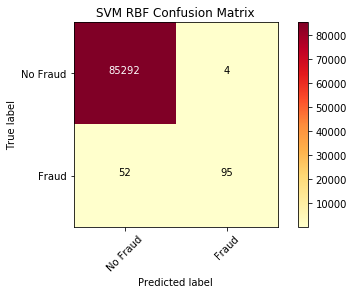

In [44]:
#Create confusion matrix
cnf_matrix = confusion_matrix(target_test, target_predicted_svm_rbf)
#Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Fraud', 'Fraud'],
                      title='SVM RBF Confusion Matrix')

plt.show()

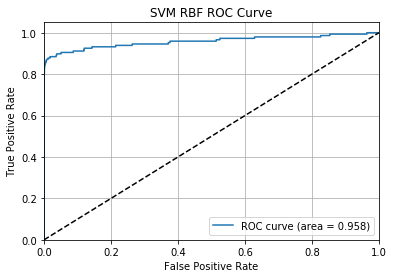

In [45]:
# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(target_test, svm_rbf.predict_proba(features_test)[:,1]) 
    
# Calculate the AUC
roc_auc = auc(fpr, tpr)
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM RBF ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Neural Network

In [46]:
#Set clf function
nn = MLPClassifier()
#Print clf function
print(nn)
#Set parameters
parameters = { 'hidden_layer_sizes': [x for x in itertools.product((10,30,50,100),repeat=1) and itertools.product((10,30,50,100),repeat=2)]}
#Set grid search function
grid_search = GridSearchCV(nn, parameters, cv=5, scoring='recall')
#Run grid search
grid_search.fit(features_train, target_train)
print("Best:", grid_search.best_params_)  

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
Best: {'hidden_layer_sizes': (30, 10)}


In [102]:
#Set clf function
nn = MLPClassifier(hidden_layer_sizes=(30,10))
#Fit clf to the training data
nn = nn.fit(features_train, target_train)
#Predict clf DT model again test data
target_predicted_nn = nn.predict(features_test)
print("Neural Network Recall Score", recall_score(target_test, target_predicted_nn))
print(classification_report(target_test, target_predicted_nn,target_names=['No Fraud', 'Fraud']))

Neural Network Recall Score 0.741496598639
             precision    recall  f1-score   support

   No Fraud       1.00      1.00      1.00     85296
      Fraud       0.88      0.74      0.80       147

avg / total       1.00      1.00      1.00     85443



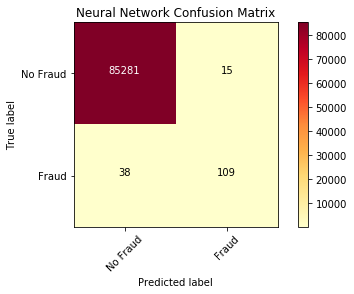

In [103]:
#Create confusion matrix
cnf_matrix = confusion_matrix(target_test, target_predicted_nn)
#Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Fraud', 'Fraud'],
                      title='Neural Network Confusion Matrix')

plt.show()

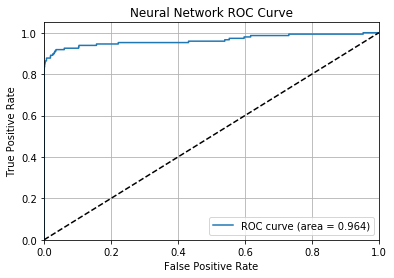

In [104]:
# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(target_test, nn.predict_proba(features_test)[:,1]) 
    
# Calculate the AUC
roc_auc = auc(fpr, tpr)
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Neural Network ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Stochastic Gradient Descent

In [50]:
#Set clf function
sgd = SGDClassifier(n_jobs=-1,random_state=0)
#Print clf function
print(sgd)
#Set parameters
parameters = { 'loss':['log', 'modified_huber'],'penalty':['l2', 'l1', 'elasticnet'],'class_weight':[None,'balanced']}
#Set grid search function
grid_search = GridSearchCV(sgd, parameters, cv=5, scoring='recall')
#Run grid search
grid_search.fit(features_train, target_train)
print("Best:", grid_search.best_params_)  

/Users/connormccambridge/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=0, shuffle=True,
       tol=None, verbose=0, warm_start=False)
Best: {'class_weight': 'balanced', 'loss': 'log', 'penalty': 'l1'}


In [105]:
#Set clf function
sgd = SGDClassifier(class_weight='balanced',loss='log',penalty='l1',n_jobs=-1,random_state=0)
#Fit clf to the training data
sgd = sgd.fit(features_train, target_train)
#Predict clf DT model again test data
target_predicted_sgd = sgd.predict(features_test)
print("Stochastic Gradient Descent Recall Score", recall_score(target_test, target_predicted_sgd))
print(classification_report(target_test, target_predicted_sgd,target_names=['No Fraud', 'Fraud']))

/Users/connormccambridge/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Stochastic Gradient Descent Recall Score 0.925170068027
             precision    recall  f1-score   support

   No Fraud       1.00      0.96      0.98     85296
      Fraud       0.04      0.93      0.08       147

avg / total       1.00      0.96      0.98     85443



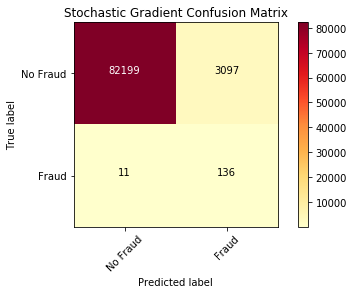

In [106]:
#Create confusion matrix
cnf_matrix = confusion_matrix(target_test, target_predicted_sgd)
#Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Fraud', 'Fraud'],
                      title='Stochastic Gradient Confusion Matrix')

plt.show()

/Users/connormccambridge/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


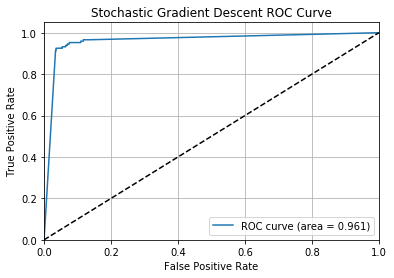

In [107]:
# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(target_test, sgd.predict_proba(features_test)[:,1]) 
    
# Calculate the AUC
roc_auc = auc(fpr, tpr)
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Stochastic Gradient Descent ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## AdaBoost Classifier

In [54]:
#Set clf function
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4))
#Print clf function
print(bdt)
#Set parameters
parameters = {'algorithm':['SAMME','SAMME.R'],'n_estimators':[10,20,50,100]}
#Set grid search function
grid_search = GridSearchCV(bdt,parameters,cv=5, scoring='recall')
#Run grid search
grid_search.fit(features_train, target_train)
print("Best:", grid_search.best_params_)  

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None)
Best: {'algorithm': 'SAMME', 'n_estimators': 100}


In [108]:
#Set clf function
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4), algorithm="SAMME", n_estimators=100)
#Fit clf to the training data
bdt = bdt.fit(features_train, target_train)
#Predict clf model again test data
target_predicted_bdt = bdt.predict(features_test)
print("AdaBoost Classifier Recall Score", recall_score(target_test, target_predicted_bdt))
print(classification_report(target_test, target_predicted_bdt,target_names=['No Fraud', 'Fraud']))

AdaBoost Classifier Recall Score 0.748299319728
             precision    recall  f1-score   support

   No Fraud       1.00      1.00      1.00     85296
      Fraud       0.96      0.75      0.84       147

avg / total       1.00      1.00      1.00     85443



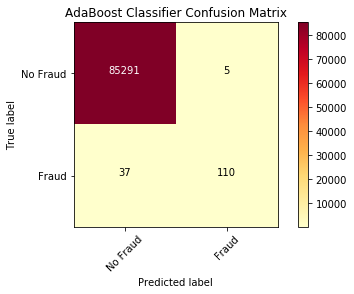

In [109]:
#Create confusion matrix
cnf_matrix = confusion_matrix(target_test, target_predicted_bdt)
#Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Fraud', 'Fraud'],
                      title='AdaBoost Classifier Confusion Matrix')

plt.show()

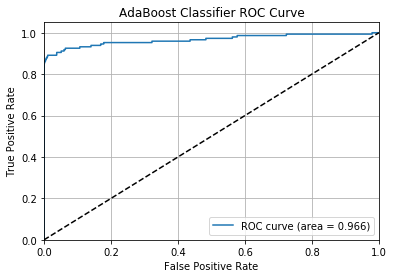

In [110]:
# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(target_test, bdt.predict_proba(features_test)[:,1]) 
    
# Calculate the AUC
roc_auc = auc(fpr, tpr)
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AdaBoost Classifier ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Bagging Classifier

In [58]:
#Set clf function
bag = BaggingClassifier(random_state=0)
#Print clf function
print(bag)
#Set parameters
parameters = {'n_estimators':[10,20,50,100]}
#Set grid search function
grid_search = GridSearchCV(bag,parameters,cv=5, scoring='recall')
#Run grid search
grid_search.fit(features_train, target_train)
print("Best:", grid_search.best_params_)  

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
         verbose=0, warm_start=False)
Best: {'n_estimators': 100}


In [59]:
#Set clf function
bag = BaggingClassifier(n_estimators=100, random_state=0)
#Fit clf to the training data
bag = bag.fit(features_train, target_train)
#Predict clf model again test data
target_predicted_bag = bag.predict(features_test)
print("Bagging Classifier Recall Score", recall_score(target_test, target_predicted_bag))
print(classification_report(target_test, target_predicted_bag,target_names=['No Fraud', 'Fraud']))

Bagging Classifier Recall Score 0.775510204082
             precision    recall  f1-score   support

   No Fraud       1.00      1.00      1.00     85296
      Fraud       0.95      0.78      0.85       147

avg / total       1.00      1.00      1.00     85443



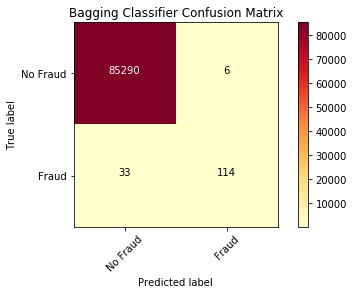

In [60]:
#Create confusion matrix
cnf_matrix = confusion_matrix(target_test, target_predicted_bag)
#Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Fraud', 'Fraud'],
                      title='Bagging Classifier Confusion Matrix')

plt.show()

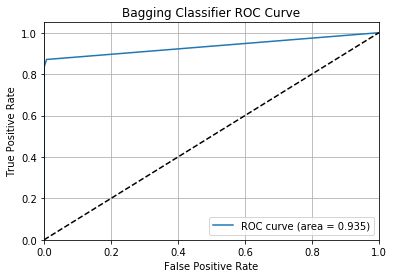

In [61]:
# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(target_test, bag.predict_proba(features_test)[:,1]) 
    
# Calculate the AUC
roc_auc = auc(fpr, tpr)
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Bagging Classifier ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Gradient Boosting

In [62]:
#Set clf function
gbc = GradientBoostingClassifier(learning_rate=1.7, max_depth=1, random_state=0)
#Print clf function
print(gbc)
#Set parameters
parameters = {'loss':['deviance','exponential'],'n_estimators':[10,20,50,100]}
#Set grid search function
grid_search = GridSearchCV(gbc,parameters,cv=5, scoring='recall')
#Run grid search
grid_search.fit(features_train, target_train)
print("Best:", grid_search.best_params_)  

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1.7, loss='deviance', max_depth=1,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)
Best: {'loss': 'exponential', 'n_estimators': 50}


In [63]:
#Set clf function
gbc = GradientBoostingClassifier(loss='exponential',n_estimators=50, learning_rate=1.7, max_depth=1, random_state=0)
#Fit clf to the training data
gbc = gbc.fit(features_train, target_train)
#Predict clf model again test data
target_predicted_gbc = gbc.predict(features_test)
print("Gradient Boosting Recall Score", recall_score(target_test, target_predicted_gbc))
print(classification_report(target_test, target_predicted_gbc,target_names=['No Fraud', 'Fraud']))

Gradient Boosting Recall Score 0.52380952381
             precision    recall  f1-score   support

   No Fraud       1.00      1.00      1.00     85296
      Fraud       0.89      0.52      0.66       147

avg / total       1.00      1.00      1.00     85443



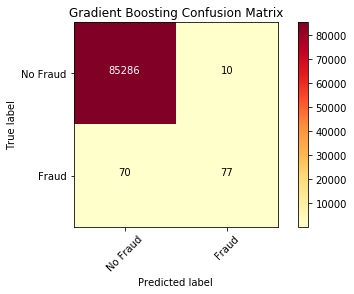

In [64]:
#Create confusion matrix
cnf_matrix = confusion_matrix(target_test, target_predicted_gbc)
#Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Fraud', 'Fraud'],
                      title='Gradient Boosting Confusion Matrix')

plt.show()

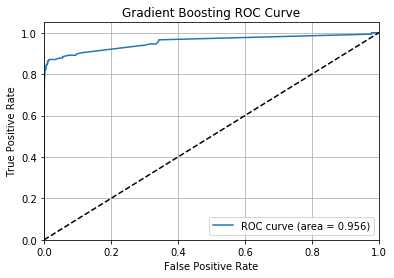

In [65]:
# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(target_test, gbc.predict_proba(features_test)[:,1]) 
    
# Calculate the AUC
roc_auc = auc(fpr, tpr)
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gradient Boosting ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

## Extra Trees

In [66]:
#Set clf function
xdt = ExtraTreesClassifier(max_depth=3,random_state=0)
#Print clf function
print(xdt)
#Set parameters
parameters = {'n_estimators':[10,20,50,100],'class_weight':[None,'balanced']}
#Set grid search function
grid_search = GridSearchCV(xdt,parameters,cv=5, scoring='recall')
#Run grid search
grid_search.fit(features_train, target_train)
print("Best:", grid_search.best_params_)  

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=3, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)
Best: {'class_weight': 'balanced', 'n_estimators': 10}


In [67]:
#Set clf function
xdt = ExtraTreesClassifier(class_weight='balanced',n_estimators=10,max_depth=3,random_state=0)
#Fit clf to the training data
xdt = xdt.fit(features_train, target_train)
#Predict clf model again test data
target_predicted_xdt = xdt.predict(features_test)
print("Extra Trees Recall Score", recall_score(target_test, target_predicted_xdt))
print(classification_report(target_test, target_predicted_xdt,target_names=['No Fraud', 'Fraud']))

Extra Trees Recall Score 0.857142857143
             precision    recall  f1-score   support

   No Fraud       1.00      0.99      1.00     85296
      Fraud       0.16      0.86      0.27       147

avg / total       1.00      0.99      0.99     85443



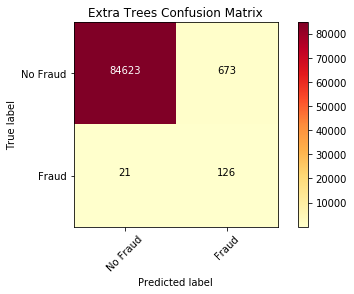

In [68]:
#Create confusion matrix
cnf_matrix = confusion_matrix(target_test, target_predicted_xdt)
#Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Fraud', 'Fraud'],
                      title='Extra Trees Confusion Matrix')

plt.show()

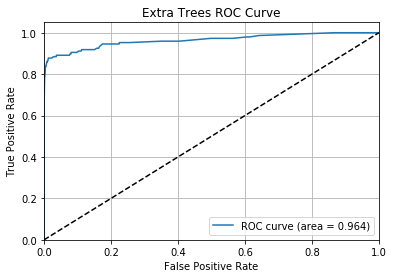

In [69]:
# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(target_test, xdt.predict_proba(features_test)[:,1]) 
    
# Calculate the AUC
roc_auc = auc(fpr, tpr)
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Extra Trees ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Initial Results

In [ ]:
#Creating dataframe for results
recall_scores=[]
names=[]
roc_scores=[]
#Running criss validation
all_clf = [gnb, lr, knn, dt, rf, svm_l, svm_rbf, nn, sgd, bdt, bag, gbc, xdt]
clf_labels = ['Gaussian Naive Bayes', 'Logistic Regression', 'Knn', 'Decision Tree', 'Random Forest', 'SVM Linear', 'SVM RBF', 'Neural Network', 'Stochastic Gradient Descent', 'AdaBoost Classifier', 'Bagging Classifier', 'Gradient Boosting', 'Extra Trees']
for MV, label in zip(all_clf, clf_labels):
    all_scores = cross_val_score(MV, features_train, target_train, cv=5, scoring='recall')
    print("Recall: %0.4f (Max-Min %0.4f) [%s]" % (all_scores.mean(), all_scores.max()-all_scores.min(), label))
    recall_scores.append(all_scores)
    names.append(label)
for MV, label in zip(all_clf, clf_labels):
    all_scores2 = cross_val_score(MV, features_train, target_train, cv=5, scoring='roc_auc')
    print("ROC AUC: %0.4f (+/- %0.4f) [%s]" % (all_scores2.mean(), all_scores2.std(), label))
    roc_scores.append(all_scores2)

Recall: 0.8103 (Max-Min 0.2244) [Gaussian Naive Bayes]
Recall: 0.5397 (Max-Min 0.3846) [Logistic Regression]
Recall: 0.7128 (Max-Min 0.5000) [Knn]
Recall: 0.6987 (Max-Min 0.3846) [Decision Tree]
Recall: 0.7128 (Max-Min 0.4615) [Random Forest]
Recall: 0.6179 (Max-Min 0.4615) [SVM Linear]


# Stacking

In [31]:
#Standard scaling linear regression and knn
pipe1 = Pipeline([['sc', StandardScaler()],
                  ['lr', lr]])
pipe2 = Pipeline([['sc', StandardScaler()],
                  ['knn', knn]])

In [112]:
#Set clf function
stack1 = MajorityVoteClassifier(classifiers=[gnb, sgd, xdt])
#Fit clf to the training data
stack1 = stack1.fit(features_train, target_train)
#Predict clf model again test data
target_predicted_stack1 = stack1.predict(features_test)
print("Stack gnb/sgd/xdt Recall Score", recall_score(target_test, target_predicted_stack1))
print(classification_report(target_test, target_predicted_stack1,target_names=['No Fraud', 'Fraud']))

Stack gnb/sgd/xdt Recall Score 0.877551020408
             precision    recall  f1-score   support

   No Fraud       1.00      0.99      1.00     85296
      Fraud       0.17      0.88      0.28       147

avg / total       1.00      0.99      0.99     85443



In [29]:
stack1 = MajorityVoteClassifier(classifiers=[gnb, sgd, xdt])

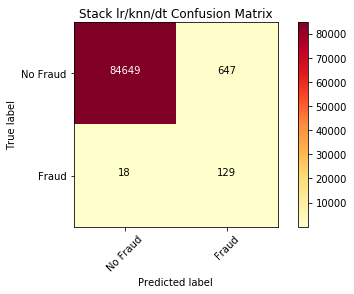

In [113]:
#Create confusion matrix
cnf_matrix = confusion_matrix(target_test, target_predicted_stack1)
#Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Fraud', 'Fraud'],
                      title='Stack gnb/sgd/xdt Confusion Matrix')

plt.show()

In [114]:
#Set clf function
stack2 = MajorityVoteClassifier(classifiers=[pipe1, bdt, xdt])
#Fit clf to the training data
stack2 = stack2.fit(features_train, target_train)
#Predict clf model again test data
target_predicted_stack2 = stack2.predict(features_test)
print("Stack lr/bdt/xdt Recall Score", recall_score(target_test, target_predicted_stack2))
print(classification_report(target_test, target_predicted_stack2,target_names=['No Fraud', 'Fraud']))

Stack lr/bdt/xdt Recall Score 0.761904761905
             precision    recall  f1-score   support

   No Fraud       1.00      1.00      1.00     85296
      Fraud       0.90      0.76      0.83       147

avg / total       1.00      1.00      1.00     85443



In [32]:
stack2 = MajorityVoteClassifier(classifiers=[pipe1, bdt, xdt])

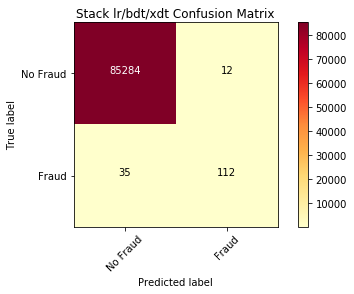

In [115]:
#Create confusion matrix
cnf_matrix = confusion_matrix(target_test, target_predicted_stack2)
#Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Fraud', 'Fraud'],
                      title='Stack lr/bdt/xdt Confusion Matrix')

plt.show()

In [116]:
#Set clf function
stack3 = MajorityVoteClassifier(classifiers=[pipe1, svm_rbf, gbc])
#Fit clf to the training data
stack3 = stack3.fit(features_train, target_train)
#Predict clf model again test data
target_predicted_stack3 = stack3.predict(features_test)
print("Stack lr/svm_rbf/gbc Recall Score", recall_score(target_test, target_predicted_stack3))
print(classification_report(target_test, target_predicted_stack3,target_names=['No Fraud', 'Fraud']))

Stack lr/svm_rbf/gbc Recall Score 0.666666666667
             precision    recall  f1-score   support

   No Fraud       1.00      1.00      1.00     85296
      Fraud       0.95      0.67      0.78       147

avg / total       1.00      1.00      1.00     85443



In [33]:
stack3 = MajorityVoteClassifier(classifiers=[pipe1, svm_rbf, gbc])

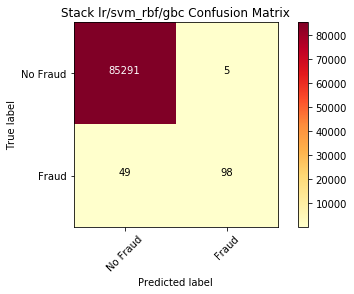

In [117]:
#Create confusion matrix
cnf_matrix = confusion_matrix(target_test, target_predicted_stack3)
#Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Fraud', 'Fraud'],
                      title='Stack lr/svm_rbf/gbc Confusion Matrix')

plt.show()

In [118]:
#Set clf function
stack4 = MajorityVoteClassifier(classifiers=[pipe2, dt, svm_l])
#Fit clf to the training data
stack4 = stack4.fit(features_train, target_train)
#Predict clf model again test data
target_predicted_stack4 = stack4.predict(features_test)
print("Stack knn/dt/svm_l Recall Score", recall_score(target_test, target_predicted_stack4))
print(classification_report(target_test, target_predicted_stack4,target_names=['No Fraud', 'Fraud']))

Stack knn/dt/svm_l Recall Score 0.795918367347
             precision    recall  f1-score   support

   No Fraud       1.00      1.00      1.00     85296
      Fraud       0.95      0.80      0.87       147

avg / total       1.00      1.00      1.00     85443



In [34]:
stack4 = MajorityVoteClassifier(classifiers=[pipe2, dt, svm_l])

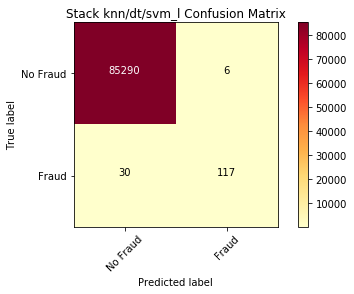

In [119]:
#Create confusion matrix
cnf_matrix = confusion_matrix(target_test, target_predicted_stack4)
#Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Fraud', 'Fraud'],
                      title='Stack knn/dt/svm_l Confusion Matrix')

plt.show()

In [121]:
#Set clf function
stack5 = MajorityVoteClassifier(classifiers=[svm_l, nn, sgd])
#Fit clf to the training data
stack5 = stack5.fit(features_train, target_train)
#Predict clf model again test data
target_predicted_stack5 = stack5.predict(features_test)
print("Stack svm_l/nn/sgd Recall Score", recall_score(target_test, target_predicted_stack5))
print(classification_report(target_test, target_predicted_stack5,target_names=['No Fraud', 'Fraud']))

Stack svm_l/nn/sgd Recall Score 0.802721088435
             precision    recall  f1-score   support

   No Fraud       1.00      1.00      1.00     85296
      Fraud       0.84      0.80      0.82       147

avg / total       1.00      1.00      1.00     85443



In [35]:
stack5 = MajorityVoteClassifier(classifiers=[svm_l, nn, sgd])

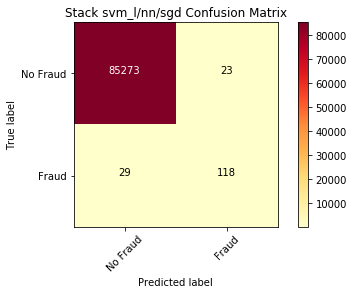

In [122]:
#Create confusion matrix
cnf_matrix = confusion_matrix(target_test, target_predicted_stack5)
#Plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Fraud', 'Fraud'],
                      title='Stack svm_l/nn/sgd Confusion Matrix')

plt.show()

In [36]:
all_stack = [stack1,stack2,stack3,stack4,stack5]
stack_label = ['gnb/sgd/xdt','lr/bdt/xdt','lr/svm_rbf/gbc','knn/dt/svm_l','svm_l/nn/sgd']

/Users/connormccambridge/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/connormccambridge/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


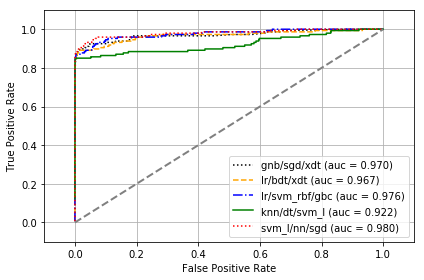

In [124]:
colors = ['black', 'orange', 'blue', 'green','red']
linestyles = [':', '--', '-.', '-',':']

for clf, label, clr, ls \
        in zip(all_stack, 
               stack_label, colors, linestyles):

    # assuming the label of the positive class is 1
    y_pred = clf.fit(features_train, 
                     target_train).predict_proba(features_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=target_test, 
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, 
             color=clr, 
             linestyle=ls, 
             label='%s (auc = %0.3f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 
         linestyle='--', 
         color='gray', 
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.tight_layout()
plt.show()

In [ ]:
all_stack = [stack1,stack2,stack3,stack4,stack5]
stack_label = ['Stack gnb/sgd/xdt','Stack lr/bdt/xdt','Stack lr/svm_rbf/gbc','Stack knn/dt/svm_l','Stack svm_l/nn/sgd']
for MSV, label in zip(all_stack,stack_label):
    ms_scores = cross_val_score(MSV, features_train, target_train, cv=5, scoring='recall')
    print("Recall: %0.4f (Max-Min %0.4f) [%s]" % (ms_scores.mean(), ms_scores.max()-ms_scores.min(), label)) 
    recall_scores.append(ms_scores)
    names.append(label)
for MSV, label in zip(all_stack,stack_label):   
    ms_scores2 = cross_val_score(MSV, features_train, target_train, cv=5, scoring='roc_auc')
    print("ROC AUC: %0.4f (+/- %0.4f) [%s]" % (ms_scores2.mean(), ms_scores2.std(), label))
    roc_scores.append(ms_scores2)

Recall: 0.8551 (Max-Min 0.1014) [Stack gnb/sgd/xdt]
Recall: 0.7942 (Max-Min 0.0725) [Stack lr/bdt/xdt]
Recall: 0.7217 (Max-Min 0.1159) [Stack lr/svm_rbf/gbc]


# Results

In [126]:
all_clf = [stack1]
clf_labels = ['Stacking gnb/sgd/xdt']

recall_scores=[]
names=[]
roc_scores=[]

for MV, label in zip(all_clf, clf_labels):
    all_scores = cross_val_score(MV, features_train, target_train, cv=5, scoring='recall')
    print("Recall: %0.4f (Max-Min: %0.4f) [%s]" % (all_scores.mean(), all_scores.max()-all_scores.min(), label))
    recall_scores.append(all_scores)
    names.append(label)
for MV, label in zip(all_clf, clf_labels):
    all_scores2 = cross_val_score(MV, features_train, target_train, cv=5, scoring='roc_auc')
    print("ROC AUC: %0.4f (+/- %0.4f) [%s]" % (all_scores2.mean(), all_scores2.std(), label))
    roc_scores.append(all_scores2)

Recall: 0.8261 (Max-Min: 0.1014) [Gaussian Naive Bayes]
Recall: 0.6203 (Max-Min: 0.1739) [Logistic Regression]
Recall: 0.7739 (Max-Min: 0.0580) [Knn]
Recall: 0.7594 (Max-Min: 0.1304) [Decision Tree]
Recall: 0.7913 (Max-Min: 0.0725) [Random Forest]
Recall: 0.7826 (Max-Min: 0.0290) [SVM Linear]
Recall: 0.6754 (Max-Min: 0.0725) [SVM RBF]
Recall: 0.7855 (Max-Min: 0.1594) [Neural Network]
Recall: 0.9507 (Max-Min: 0.0870) [Stochastic Gradient Descent]
Recall: 0.7971 (Max-Min: 0.0580) [AdaBoost Classifier]
Recall: 0.7855 (Max-Min: 0.0870) [Bagging Classifier]
Recall: 0.7304 (Max-Min: 0.1014) [Gradient Boosting]
Recall: 0.8464 (Max-Min: 0.1304) [Extra Trees]
Recall: 0.7188 (Max-Min: 0.1159) [Stacking sgd/bdt/gbc]
ROC AUC: 0.9617 (+/- 0.0125) [Gaussian Naive Bayes]
ROC AUC: 0.9740 (+/- 0.0128) [Logistic Regression]
ROC AUC: 0.8869 (+/- 0.0126) [Knn]
ROC AUC: 0.8795 (+/- 0.0218) [Decision Tree]
ROC AUC: 0.9412 (+/- 0.0248) [Random Forest]
ROC AUC: 0.9322 (+/- 0.0074) [SVM Linear]
ROC AUC: 0.9412

In [127]:
names = names[::-1]
recall_scores = recall_scores[::-1]

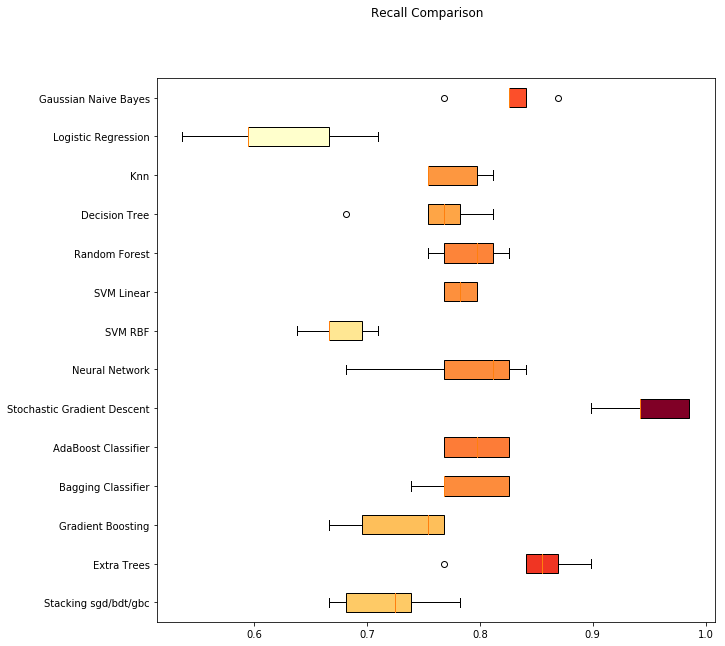

In [128]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Recall Comparison')
ax = fig.add_subplot(111)
box = plt.boxplot(recall_scores,vert=False,patch_artist=True)
cmap = cm.ScalarMappable(cmap='YlOrRd')
test_mean = [np.mean(x) for x in recall_scores]
for patch, color in zip(box['boxes'], cmap.to_rgba(test_mean)):
    patch.set_facecolor(color)
ax.set_yticklabels(names)
plt.show()

In [129]:
roc_scores = roc_scores[::-1]

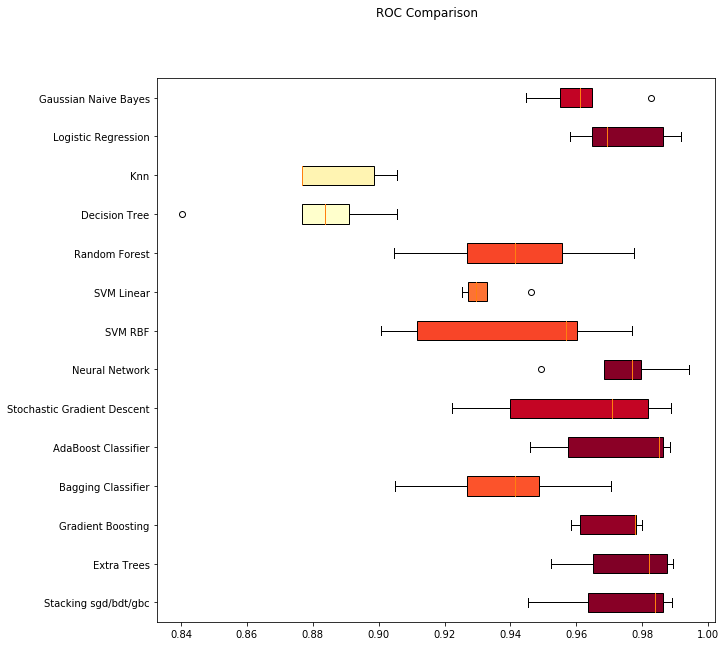

In [130]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle('ROC Comparison')
ax = fig.add_subplot(111)
box = plt.boxplot(roc_scores,vert=False,patch_artist=True)
cmap = cm.ScalarMappable(cmap='YlOrRd')
test_mean = [np.mean(x) for x in roc_scores]
for patch, color in zip(box['boxes'], cmap.to_rgba(test_mean)):
    patch.set_facecolor(color)
ax.set_yticklabels(names)
plt.show()

| Model      | Best Model Parameters | Recall    | AUC |
| :-------: | :----:| :-------: | :----:|
| Gaussian Naïve Bayes | | 0.8261  |0.9617|
|Logistic Regression    |  penalty='L2', c=10 |0.6203|0.9740|
|Knn    |  n_neighbors=1, weights='uniform'|0.7739|0.8869|
|Decision Tree    |  class_weight=None, criterion='entropy', max_features=None, splitter='best' |0.7594|0.8795|
|Random Forest  |  class_weight=None, criterion='gini', max_features=None, n_estimators=100 |0.7913|0.9412|
|SVM Linear   |  C=0.01 |0.7826|0.9322|
|SVM RBF  |  C=10|0.6754|0.9412|
|Neural Network  |  hidden_layer_sizes=(30,10) |0.7855|0.9738|
|Stochastic Gradient Descent   |  class_weight='balanced', loss='log', penalty='l1'|0.9507|0.9607|
|AdaBoost  |  algorithm="SAMME", n_estimators=100 |0.7971|0.9727|
|Bagging Classifier   |  n_estimators=100|0.7855|0.9385|
|Gradient Boosting   |  loss='exponential', n_estimators=50|0.7304|0.9711|
|Extra Trees |  class_weight='balanced', n_estimators=10 |0.8464|0.9752|
|Stacking   |  Stacked models= Gaussian Naïve Bayes / Stochastic Gradient Descent / Extra Trees|0.7188|0.9736|